# Using OPeNDAP to Access Data from the Earthdata Cloud Archives

### Overview

This notebook demonstrates how to access OPeNDAP granules hosted inside of the Earthdata Cloud Archives. It shows how to query a cloud OPeNDAP-hosted Daymet granule using the Common Metadata Repository (CMR) API, before remotely accessing and analyzing it using Xarray and ncdump.

### Review: What is OPeNDAP?

OPeNDAP, or the [Open-source Project for a Network Data Access Protocol](https://www.earthdata.nasa.gov/engage/open-data-services-and-software/api/opendap), is a data server that allows for accessing scientific datasets through the public internet. It uses Data Access Protocols (DAP) and the [Hyrax Data Server](https://www.opendap.org/software/hyrax-data-server), to distribute data and metadata to various clients and utilities, including Python. NASA and its [Distributed Active Archive Centers (DAACs)](https://www.earthdata.nasa.gov/eosdis/daacs) are migrating their on-premise OPeNDAP Hyrax servers to the cloud, where granules are now organized by DAAC and collection [Concept ID](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html#c-concept-id). This notebook will show how to search for [Daymet](https://daymet.ornl.gov/) Concept ID and OPeNDAP URLs using the [CMR API](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html), before viewing and plotting its data through several methods, including [Xarray](https://docs.xarray.dev/en/stable/) and [ncdump](https://www.unidata.ucar.edu/software/netcdf/workshops/2011/utilities/Ncdump.html).

### Prerequisites

- A valid [Earthdata Login account](https://urs.earthdata.nasa.gov/)
- Python 3.7 or higher
- [Xarray](https://docs.xarray.dev/en/stable/)
- [netcdf4-python](https://unidata.github.io/netcdf4-python/) version >= 4.8.0
    - To check the version of your library, call the following function: <code>nc4.getlibversion()</code>

---

## 1. Import Packages

In [1]:
import xarray as xr
import requests
import earthaccess
import datetime as dt
import pprint
import netCDF4 as nc4

## 2. Create EDL files using the <code>earthaccess</code> Python library

In [2]:
auth = earthaccess.login(strategy="interactive", persist=True) 

You're now authenticated with NASA Earthdata Login
Using token with expiration date: 05/12/2023
Using user provided credentials for EDL
Persisting credentials to .netrc


## 3. Finding Data Files in NASA's EarthData Cloud: or What's a ConceptID?

Cloud OPeNDAP-enabled granules are organized b a unique identifier called the **`Concept ID`**. Below, we'll demonstrate how to use NASA's [**CMR API**](https://cmr.earthdata.nasa.gov/search) and either the Daymet dataset `DOI` or the `shortname` to obtain the Concept ID for **Daymet Daily** data.  With this information, we can search all of NASA's Earthdata holdings for matching data files (granules) based on our spatial area and time period of interest.

Search NASA Earthdata Holdings based on...
* *`DOI`* - The Daymet daily data Digital Object Identifier
* *`ConceptID`* - remember, this is NASA Earthdata's unique ID for this dataset
* Area of Interest
* Time Range of Interest

## 3.1 Obtaining the Daymet V4 Daily data *Concept ID*
Using Python's **`requests`** library, we will build and provide the URL `doisearch` to search **NASA's Common Metadata Repository (CMR)** to acquire the **`concept_id`** unique to the Daymet V4 Daily data in NASA's Cloud holdings.  We'll use the **concept_id** in a next step when we search NASA Cloud Holdings for our spatial and temporal area of interest.

In [3]:
# CMR API base url
cmrurl='https://cmr.earthdata.nasa.gov/search/' # define the base url of NASA's CMR API as the variable `cmrurl`
doi = '10.3334/ORNLDAAC/2129'                   # Daymet V4R1 DOI - define the DOI as the variable `daymet_doi`
doisearch = cmrurl + 'collections.json?doi=' + doi
print(doisearch)

concept_id = requests.get(doisearch).json()['feed']['entry'][0]['id']
print(concept_id)

https://cmr.earthdata.nasa.gov/search/collections.json?doi=10.3334/ORNLDAAC/2129
C2532426483-ORNL_CLOUD


## 4. Searching for Daymet Files using the CMR Search API
Daymet daily data files (or granules) are in netCDF4 format, and each file has one year's worth of data. Data files are organized by variables (each for dayl, prcp, tmin, tmax, srad, swe, vp) and regions (each for us, pr, hi).  Daymet filenames can be used to identify the files from continental North America (`*_na_*.nc`). The files from Puerto Rico and Hawaii are named as (`*_pr_*.nc`) and (`*_hi_*.nc`) respectively.

<div class="alert alert-block alert-info">
https://cmr.earthdata.nasa.gov/search/granules
</div>

Below, we create appropriately formatted strings for our temporal range:

In [4]:
start_date = dt.datetime(2010, 1, 1) # specify your own start date
end_date = dt.datetime(2011, 12, 31)  # specify your end start date
print(start_date,end_date,sep='\n')

dt_format = '%Y-%m-%dT%H:%M:%SZ' # format requirement for datetime search
temporal_str = start_date.strftime(dt_format) + ',' + end_date.strftime(dt_format)
print(temporal_str)

2010-01-01 00:00:00
2011-12-31 00:00:00
2010-01-01T00:00:00Z,2011-12-31T00:00:00Z


We will first search all the granules for the full extent, and time period of interest (2010, 2011).  For this tutorial, we set up the search parameters and download maximum temperature data (`tmax`).

In [5]:
cmr_url = 'https://cmr.earthdata.nasa.gov/search/granules'

cmr_response = requests.get(cmr_url, 
                            params={
                                'concept_id': concept_id,
                                'temporal': temporal_str,
                                'page_size': 200,
                                },
                            headers={
                                'Accept': 'application/json'
                                }
                            )

daymet_granules = cmr_response.json()['feed']['entry']

daymet_granules_urls = []

for granule in daymet_granules:
    item = next((item['href'] for item in granule['links'] if "opendap" in item["href"] and "tmax" in item["href"]), None)
    if item != None:
        daymet_granules_urls.append(item)

daymet_granules_urls

['https://opendap.earthdata.nasa.gov/collections/C2532426483-ORNL_CLOUD/granules/Daymet_Daily_V4R1.daymet_v4_daily_hi_tmax_2010.nc',
 'https://opendap.earthdata.nasa.gov/collections/C2532426483-ORNL_CLOUD/granules/Daymet_Daily_V4R1.daymet_v4_daily_na_tmax_2010.nc',
 'https://opendap.earthdata.nasa.gov/collections/C2532426483-ORNL_CLOUD/granules/Daymet_Daily_V4R1.daymet_v4_daily_pr_tmax_2010.nc',
 'https://opendap.earthdata.nasa.gov/collections/C2532426483-ORNL_CLOUD/granules/Daymet_Daily_V4R1.daymet_v4_daily_hi_tmax_2011.nc',
 'https://opendap.earthdata.nasa.gov/collections/C2532426483-ORNL_CLOUD/granules/Daymet_Daily_V4R1.daymet_v4_daily_pr_tmax_2011.nc',
 'https://opendap.earthdata.nasa.gov/collections/C2532426483-ORNL_CLOUD/granules/Daymet_Daily_V4R1.daymet_v4_daily_na_tmax_2011.nc']

## 5. Open and Subset Granules Using netcdf4-python and the DAP4 Protocol

The "[DAP4](https://docs.opendap.org/index.php/DAP4:_Overview)" protocol is included with Cloud OPeNDAP-enabled granules. This allows for certain granules to have their variables organized into group hierarchies, complex variable names retrieved, and to further distinguish dataset variables between each other. Because of this difference over on-premises OPeNDAP, which used DAP2, certain programming libraries may require updated methods for accessing Cloud OPeNDAP-enabled granules.

**It is required to use the <code>dap4://</code> protocol in the URL instead of <code>https://</code> for the netcdf4-python library.** Before the first granule in the list is accessed, we first replace the URL protocol in the string, then view its metadata using the netcdf4-python library. 

In [6]:
#dap4_url = daymet_granules_urls.replace("https://", "dap4://")
dap4_url = [url.replace("https://", "dap4://") for url in daymet_granules_urls]

f = nc4.Dataset(dap4_url[0], 'r') # HI in 2010
f

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format DAP4):
    start_year: 2010
    source: Daymet Software Version 4.0
    Version_software: Daymet Software Version 4.0
    Version_data: Daymet Data Version 4.0
    Conventions: CF-1.6
    citation: Please see http://daymet.ornl.gov/ for current Daymet data citation information
    references: Please see http://daymet.ornl.gov/ for current information on Daymet references
    dimensions(sizes): y(584), x(284), time(365), nv(2)
    variables(dimensions): float32 y(y), float32 lon(y, x), float32 lat(y, x), float32 time(time), float32 x(x), float32 tmax(time, y, x), int16 lambert_conformal_conic(), float32 time_bnds(time, nv), int16 yearday(time)
    groups: 

## 6. Open and Subset Granules Using Xarray

Xarray is a commonly-used and widely supported Python library used for accessing and analyzing remotely-hosted datasets. Below, we use the <code>open_dataset()</code> function to access our first Cloud OPeNDAP Daymet granule, and to view its metadata. Only the full, raw, granule URL with the <code>https://</code> protocol may be passed into the Xarray library, and subsetting must be done using Xarray.


In [7]:
ds = xr.open_dataset(daymet_granules_urls[0]) # HI in 2010
ds

<xarray.Dataset>
Dimensions:                  (y: 584, x: 284, time: 365, nv: 2)
Coordinates:
  * y                        (y) float32 -3.9e+04 -4e+04 ... -6.21e+05 -6.22e+05
    lon                      (y, x) float32 ...
    lat                      (y, x) float32 ...
  * time                     (time) datetime64[ns] 2010-01-01T12:00:00 ... 20...
  * x                        (x) float32 -5.802e+06 -5.801e+06 ... -5.519e+06
Dimensions without coordinates: nv
Data variables:
    tmax                     (time, y, x) float32 ...
    lambert_conformal_conic  int16 ...
    time_bnds                (time, nv) datetime64[ns] ...
    yearday                  (time) int16 ...
Attributes:
    start_year:                          2010
    source:                              Daymet Software Version 4.0
    Version_software:                    Daymet Software Version 4.0
    Version_data:                        Daymet Data Version 4.0
    Conventions:                         CF-1.6
    citation:                            Please see http://daymet.ornl.gov/ f...
    references:                          Please see http://daymet.ornl.gov/ f...
    build_dmrpp_metadata.build_dmrpp:    3.20.13-563
    build_dmrpp_metadata.bes:            3.20.13-563
    build_dmrpp_metadata.libdap:         libdap-3.20.11-193
    build_dmrpp_metadata.configuration:  \n# TheBESKeys::get_as_config()\nAll...
    build_dmrpp_metadata.invocation:     build_dmrpp -c /tmp/bes_conf_p6Fo -f...

## 7. Resample and Plot tmax

Below, we will resample the tmax variable and calculate the monthly mean using Xarray's built-in functions. Then, we will plot the monthly tmax mean for the month of July in Hawaii for 2010.

In [11]:
# Monthly resample
monthly_tmax_mean = ds['tmax'].resample(time="M").mean()
monthly_tmax_mean

syntax error, unexpected $end, expecting ';'
context: Error {  code = 500; message = "ERROR: Problem encountered with BES connection. On transaction attempt:2 a PPTException was caught. Message: BES Client Failed To Start. Message: 'Could not connect to host localhost on port 10022. Connection refused (Connection refused)' ";}^
syntax error, unexpected $end, expecting ';'
context: Error {  code = 500; message = "ERROR: Problem encountered with BES connection. On transaction attempt:2 a PPTException was caught. Message: BES Client Failed To Start. Message: 'Could not connect to host localhost on port 10022. Connection refused (Connection refused)' ";}^
syntax error, unexpected $end, expecting ';'
context: Error {  code = 500; message = "ERROR: Problem encountered with BES connection. On transaction attempt:2 a PPTException was caught. Message: BES Client Failed To Start. Message: 'Could not connect to host localhost on port 10022. Connection refused (Connection refused)' ";}^


<xarray.DataArray 'tmax' (time: 12, y: 584, x: 284)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2010-01-31 2010-02-28 ... 2010-12-31
  * y        (y) float32 -3.9e+04 -4e+04 -4.1e+04 ... -6.21e+05 -6.22e+05
    lon      (y, x) float32 ...
    lat      (y, x) float32 ...
  * x        (x) float32 -5.802e+06 -5.801e+06 -5.8e+06 ... -5.52e+06 -5.519e+06

syntax error, unexpected $end, expecting ';'
context: Error {  code = 500; message = "ERROR: Problem encountered with BES connection. On transaction attempt:2 a PPTException was caught. Message: BES Client Failed To Start. Message: 'Could not connect to host localhost on port 10022. Connection refused (Connection refused)' ";}^


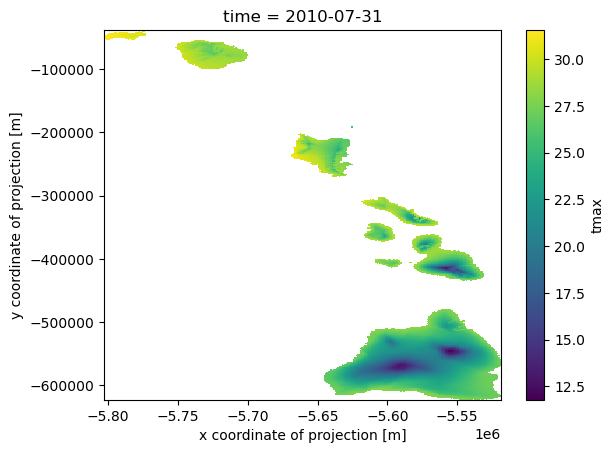

In [12]:
# Xarray plotting
monthly_tmax_mean[6,:,:].plot()